## Processing sensor data from Shale Hills CZO LRMS site ##

- Marc Berghouse 8/8/2020: Original format
- Zach Perzan 9/23/202: Improved format and working PRISM concat

This array includes:
- Apogee Instruments SO-110 O2 sensors
- Eosense EosGP CO2 sensors

Other data includes:
- PRISM daily precipitation




In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

def plot_cols(column_list, ylabel=''):
    """Plot columns from df. Columns to plot must be in
    column_list."""
    
    n = len(column_list)

    fig, ax = plt.subplots(n, figsize=(10,3*n), tight_layout=True, sharex=True)

    for i, col in enumerate(column_list):
        ax[i].plot(df.index, df[col], label=col)
        ax[i].legend(loc='upper right')
        ax[i].set(ylabel=ylabel)
        
    return fig, ax

In [2]:
infiles= ["../../raw_data/Shale Hills/TMMS/TMMS_CO2_O2.csv" ]
df_list = []

for infile in tqdm(infiles):
    df = pd.read_csv(infile, na_values=['NAN', -9999],  parse_dates=[0], 
                     index_col=0) # skiprows=[1] skips the 1th row (0-indexed)
    df_list.append(df)
    
prism_path = "../../raw_data/Shale Hills/Precipitation/PRISM_GarnerRun.csv"
ppt = pd.read_csv(prism_path, na_values=['NAN',-9999,-99999], skiprows=11, 
                  parse_dates=[0], index_col=0, names=['PRISM_precip.mm']) 
ppt['PRISM_precip.mm'] = pd.to_numeric(ppt['PRISM_precip.mm'])

In [3]:
columns=["Record", "DiffVolt_30cm.mV", "DiffVolt_80cm.mV", "O2_30cm.percent.0-100",
          "O2_80cm.percent.0-100",  "ApogeeTemp_30cm.deg.C" , "ApogeeTemp_80cm.deg.C", 
          "CO2lo_30cm.ppm","CO2hi_30cm.ppm", "GPTemp_30cm.deg.C", "CO2lo_80cm.ppm",
          "CO2hi_80cm.ppm", "GPTemp_80cm.deg.C"]



# Concatenate all individual files to a single dataframe
df = pd.concat(df_list)
df.columns = columns

# Resample everything to hourly averages since certain 
# sensors are measured on different schedules
df.sort_index(inplace=True) # Sort first
df = df.resample('1H').mean()
df
# Add on up-sampled PRISM data
# (resample daily to hourly, using the nearest value, then
#  add on as new column to df)
ppt = ppt.drop(pd.date_range('2015-06-10', '2015-06-11'), errors='ignore')
#ppt = ppt.drop(pd.date_range('2018-10-02', '2019-06-24'), errors='ignore')


hourly_ppt = ppt.resample('1H').nearest()
df.loc[hourly_ppt.index, 'PRISM_precip.mm'] = hourly_ppt['PRISM_precip.mm']

In [4]:
df=df.drop(columns="Record")
df=df.drop(columns="DiffVolt_30cm.mV")
df=df.drop(columns="DiffVolt_80cm.mV")


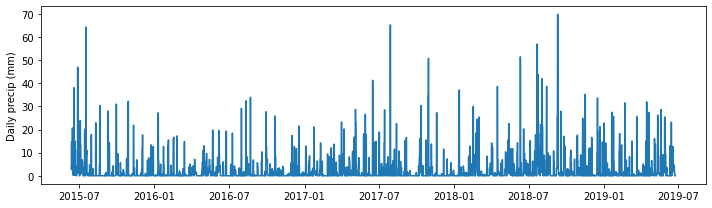

In [5]:
# Plot precip data
fig, ax = plt.subplots(figsize=(10,3), tight_layout=True)

ax.plot(df.index, df['PRISM_precip.mm'])
ax.set(ylabel='Daily precip (mm)');

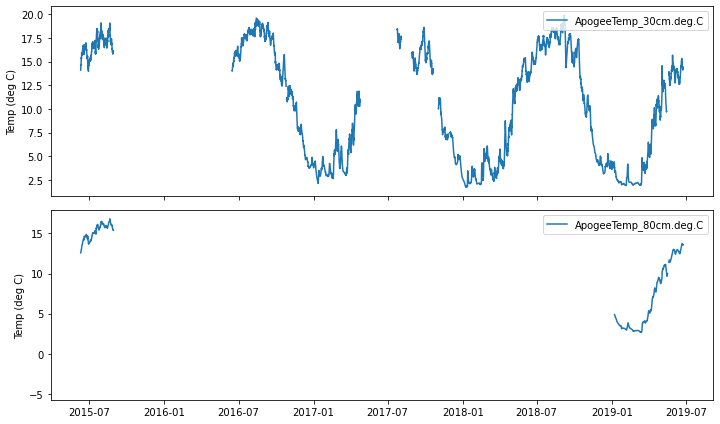

In [6]:
# Plot apogee thermistor temperature
df["ApogeeTemp_30cm.deg.C"].mask(df["ApogeeTemp_30cm.deg.C"]<=-5, inplace=True)
df["ApogeeTemp_80cm.deg.C"].mask(df["ApogeeTemp_80cm.deg.C"]<=-5, inplace=True)

apogee_temp_cols = [col for col in df.columns if 'ApogeeTemp' in col]
plot_cols(apogee_temp_cols, ylabel='Temp (deg C)');

In [7]:
df=df.drop(columns='ApogeeTemp_80cm.deg.C')


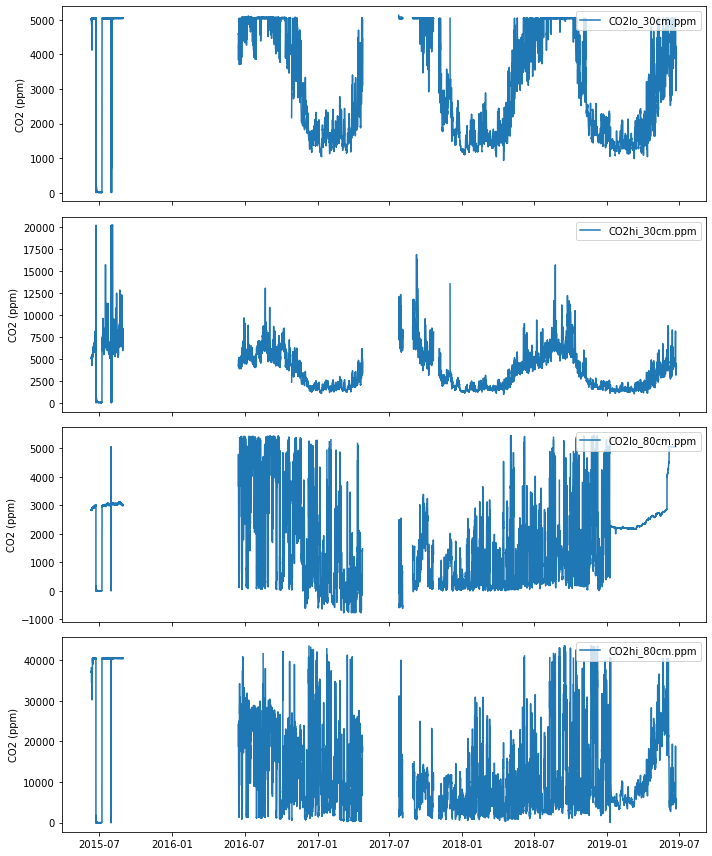

In [8]:
# Plot CO2 data
co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

In [9]:
mask = df['CO2lo_30cm.ppm'] < 5000
df.loc[mask, 'CO2_30cm.ppm'] = df.loc[mask, 'CO2lo_30cm.ppm']
df.loc[~mask, 'CO2_30cm.ppm'] = df.loc[~mask, 'CO2hi_30cm.ppm']
mask2 = df['CO2lo_80cm.ppm'] < 5000
df.loc[mask2, 'CO2_80cm.ppm'] = df.loc[mask2, 'CO2lo_80cm.ppm']
df.loc[~mask2, 'CO2_80cm.ppm'] = df.loc[~mask2, 'CO2hi_80cm.ppm']

In [10]:
df=df.drop(columns='CO2lo_30cm.ppm')
df=df.drop(columns='CO2lo_80cm.ppm')
df=df.drop(columns='CO2hi_30cm.ppm')
df=df.drop(columns='CO2hi_80cm.ppm')



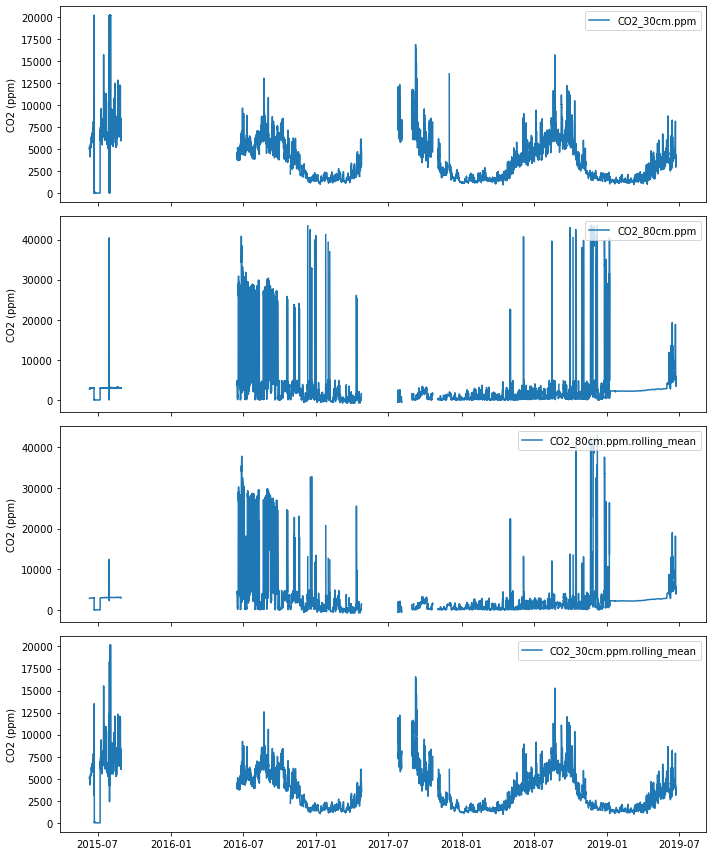

In [11]:
# Plot CO2 data
df['CO2_80cm.ppm.rolling_mean']=df['CO2_80cm.ppm'].rolling(4).mean()
df['CO2_30cm.ppm.rolling_mean']=df['CO2_30cm.ppm'].rolling(4).mean()

co2_cols = [col for col in df.columns if 'CO2' in col]
plot_cols(co2_cols, ylabel='CO2 (ppm)');

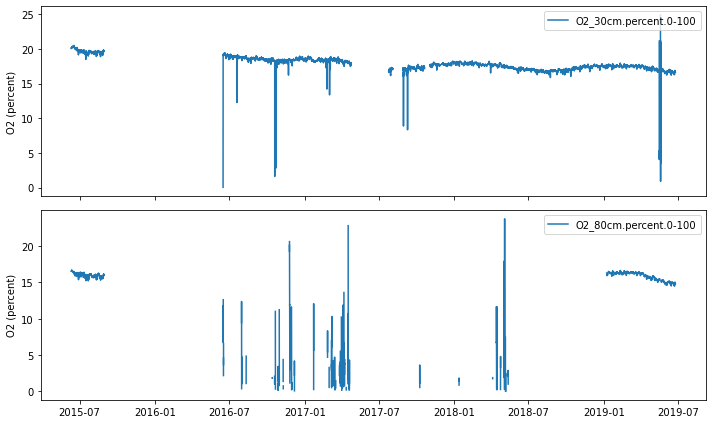

In [12]:
# Plot O2 data
# 80cm data looks unusable
df['O2_80cm.percent.0-100'].mask(df['O2_80cm.percent.0-100']>=25, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']>=25, inplace=True)
df['O2_80cm.percent.0-100'].mask(df['O2_80cm.percent.0-100']<=-.001, inplace=True)
df['O2_30cm.percent.0-100'].mask(df['O2_30cm.percent.0-100']<=-.001, inplace=True)
#df['O2_30cm.percent.0-100.rolling_mean']=df['O2_30cm.percent.0-100'].rolling(2).mean()

o2_cols = [col for col in df.columns if col[:2] == 'O2']
plot_cols(o2_cols, ylabel='O2 (percent)');

In [13]:
df=df.drop(columns='O2_80cm.percent.0-100')


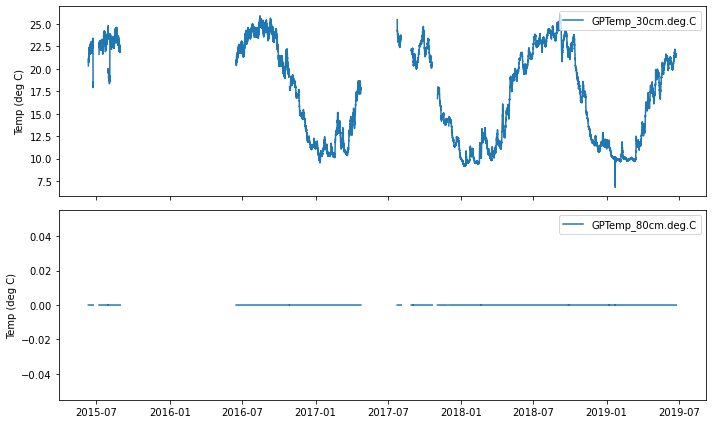

In [14]:
# Plot soil temperature from Decagon 5TE
dec_temp_cols = [col for col in df.columns if 'GPTemp' in col]

# There are several erroneous values less than -5 deg C
for col in dec_temp_cols:
    df[df[col] < -5] = np.nan
plot_cols(dec_temp_cols, ylabel='Temp (deg C)');

In [15]:
df=df.drop(columns='GPTemp_30cm.deg.C')
df=df.drop(columns='GPTemp_80cm.deg.C')



In [16]:
output=df.copy()
outfile = '../../processed_data/Shale_Hills/TMMS_CO2_O2_processed.csv'
output.to_csv(outfile, na_rep=-99999, index_label='DateTime.EST')

In [17]:
output

,O2_30cm.percent.0-100,ApogeeTemp_30cm.deg.C,PRISM_precip.mm,CO2_30cm.ppm,CO2_80cm.ppm,CO2_80cm.ppm.rolling_mean,CO2_30cm.ppm.rolling_mean
TmStamp,,,,,,,
2015-06-10 14:00:00,20.110001,14.09,NaN,5043.2441,2833.7839,NaN,NaN
2015-06-10 15:00:00,20.090000,14.17,NaN,5113.5142,2833.7839,NaN,NaN
2015-06-10 16:00:00,20.059999,14.23,NaN,4994.5952,2843.2429,NaN,NaN
2015-06-10 17:00:00,20.059999,14.30,NaN,4982.4331,2836.4871,2836.824450,5033.446650
2015-06-10 18:00:00,20.040001,14.38,NaN,5027.0269,2825.6760,2834.797475,5029.392350
...,...,...,...,...,...,...,...
2019-06-24 11:00:00,16.650000,14.36,NaN,3683.5210,4425.9971,4438.287600,3576.734025
2019-06-24 12:00:00,16.639999,14.34,NaN,3864.7151,4675.3369,4472.096800,3652.090525
2019-06-24 13:00:00,16.629999,14.33,NaN,4066.6121,5145.9888,4641.471450,3781.231275
